# EDA | Base de Crédito

- **Autor**: Arthur Brito Medeiros
- **Objetivo**: Conhecer melhor a base de treino de crédito para subsidiar decisões de implementação do chatbot com LLM. 
Fazê-la nos permitiu verificar tratamentos necessários na base para prevenir possíveis comportamentos anômalos, além de auxiliar a perceber padrões e insights que poderiam ser úteis a um analista que utilizasse o chatbot.
- **Análises realizadas**: análises estatísticas, gerais, univariadas, bivariadas, multivariadas.
- **Conclusões**: As conclusões obtidas estão sumarizadas ao fim do notebook.

**COLUNAS RELEVANTES**:

| Variável                                     | Descrição      | Tipo de variável                                       |
|-----------------------------------------------|---------------------|--------------------------------------------------|
| REF_DATE                                          | Data de referência  |       timestamp            
| TARGET                                         | Inadimplência  | binária, int (0=bom, 1=mau pagador)  
| VAR2                                       | Sexo do indíviduo.   | object (M=Masculino, F=feminino) 
| IDADE                                          | Idade em anos | float (anos)                         
| VAR4                                        | Flag de óbito. Renomeada para OBITO para análises. | object (S=sim, NaN=não)                      
| VAR5                                      | Unidade Federativa. Renomeada para UF para análises.   | estado, podendo ser nulo.                            
| VAR8                                       | Classe social estimada | object (classes de A-E, podendo ser nulo) 


As colunas categóricas (SEXO, UF, CLASSE_SOCIAL, OBITO) **NÃO são convertidas para string** neste notebook de forma proposital. Converter para string com `.astype(str)` transforma valores `NaN` verdadeiros (nulos) na string literal `"nan"`, distorcendo a análise. Mantendo as colunas como tipo `object` (sem conversão para string), preservamos os NaN verdadeiros e podemos analisá-los corretamente.

## 1. Setup e Configuração

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import locale

# Configurações
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# Configurar locale para PT-BR
try:
    locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_ALL, 'pt_BR')
    except:
        print("Aviso: Não foi possível configurar locale PT-BR")

# Estilo de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Constantes
DATA_PATH = Path('../datasets/train.gz')

# Colunas originais do arquivo
ORIGINAL_COLUMNS = ['REF_DATE', 'TARGET', 'VAR2', 'IDADE', 'VAR4', 'VAR5', 'VAR8']

# Mapeamento para nomes descritivos
COLUMN_MAPPING = {
    'VAR2': 'SEXO',
    'VAR4': 'OBITO',
    'VAR5': 'UF',
    'VAR8': 'CLASSE_SOCIAL'
}

VALID_UFS = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO',
             'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI',
             'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO']
VALID_SEXO = ['M', 'F']

print("✓ Setup concluído")

✓ Setup concluído


## 2. Funções Helper Reutilizáveis

In [ ]:
def load_data(file_path: Path, original_cols: List[str], rename_mapping: Dict[str, str]) -> pd.DataFrame:
    """
    Carrega dados do arquivo .gz e renomeia colunas para nomes descritivos.
    
    Args:
        file_path: Caminho para o arquivo .gz
        original_cols: Lista de colunas originais para carregar
        rename_mapping: Dicionário com mapeamento de nomes antigos -> novos
        
    Returns:
        DataFrame com colunas renomeadas e tipos corretos
    """
    print(f"Carregando dados de {file_path}...")
    
    # Ler colunas originais
    df = pd.read_csv(file_path, compression='gzip', usecols=original_cols)
    
    # Renomear colunas
    df = df.rename(columns=rename_mapping)
    
    # Converter tipos
    df['REF_DATE'] = pd.to_datetime(df['REF_DATE'], utc=True)
    df['TARGET'] = df['TARGET'].astype('int8')
    df['IDADE'] = pd.to_numeric(df['IDADE'], errors='coerce')
    
    print(f"Dados carregados: {len(df):,} linhas, {len(df.columns)} colunas")
    print(f"Colunas renomeadas: {list(rename_mapping.values())}")
    
    # Mostrar estatísticas de nulos
    print(f"\nValores nulos por coluna:")
    for col in df.columns:
        n_null = df[col].isna().sum()
        pct_null = (n_null / len(df)) * 100
        if n_null > 0:
            print(f"   • {col}: {n_null:,} ({pct_null:.2f}%)")
    
    return df


def calc_null_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula estatísticas de valores nulos para cada coluna.
    
    Returns:
        DataFrame com % de nulos por coluna
    """
    null_stats = pd.DataFrame({
        'coluna': df.columns,
        'n_nulos': df.isnull().sum().values,
        'pct_nulos': (df.isnull().sum() / len(df) * 100).values
    })
    return null_stats.sort_values('pct_nulos', ascending=False)


def calc_target_rate(df: pd.DataFrame, 
                      group_by: Optional[List[str]] = None,
                      min_count: int = 0) -> pd.DataFrame:
    """
    Calcula taxa de inadimplência (AVG(TARGET)) opcionalmente agrupada.
    
    Args:
        df: DataFrame
        group_by: Colunas para agrupar (None = taxa global)
        min_count: Mínimo de observações por grupo (k-anonimato)
        
    Returns:
        DataFrame com n, taxa e intervalo de confiança
    """
    if group_by is None:
        # Taxa global
        n = len(df)
        taxa = df['TARGET'].mean()
        std_err = df['TARGET'].std() / np.sqrt(n)
        ic_lower = taxa - 1.96 * std_err
        ic_upper = taxa + 1.96 * std_err
        
        return pd.DataFrame({
            'n': [n],
            'taxa_inad': [taxa],
            'ic_lower': [ic_lower],
            'ic_upper': [ic_upper]
        })
    else:
        # Agrupado
        result = df.groupby(group_by, dropna=False).agg(
            n=('TARGET', 'count'),
            taxa_inad=('TARGET', 'mean')
        ).reset_index()
        
        # Filtrar por k-anonimato
        if min_count > 0:
            result = result[result['n'] >= min_count]
        
        # Calcular IC
        result['std_err'] = np.sqrt(result['taxa_inad'] * (1 - result['taxa_inad']) / result['n'])
        result['ic_lower'] = result['taxa_inad'] - 1.96 * result['std_err']
        result['ic_upper'] = result['taxa_inad'] + 1.96 * result['std_err']
        
        return result.sort_values('taxa_inad', ascending=False)


def validate_column_values(df: pd.DataFrame, 
                           column: str, 
                           valid_values: Optional[List] = None) -> Dict:
    """
    Valida valores de uma coluna e retorna estatísticas.
    
    Args:
        df: DataFrame
        column: Nome da coluna
        valid_values: Lista de valores válidos (None = não valida)
        
    Returns:
        Dicionário com estatísticas e valores inválidos
    """
    value_counts = df[column].value_counts(dropna=False)
    n_unique = df[column].nunique()
    n_null = df[column].isnull().sum()
    
    result = {
        'coluna': column,
        'n_unique': n_unique,
        'n_null': n_null,
        'pct_null': n_null / len(df) * 100,
        'value_counts': value_counts
    }
    
    if valid_values is not None:
        invalid = df[~df[column].isin(valid_values) & df[column].notna()][column].unique()
        result['invalid_values'] = invalid
        result['n_invalid'] = len(df[~df[column].isin(valid_values) & df[column].notna()])
    
    return result


def plot_distribution(df: pd.DataFrame, 
                      column: str, 
                      kind: str = 'auto',
                      title: Optional[str] = None,
                      figsize: Tuple = (10, 5)) -> None:
    """
    Plota distribuição de uma variável.
    
    Args:
        df: DataFrame
        column: Nome da coluna
        kind: 'auto', 'hist', 'bar', 'box'
        title: Título do gráfico
        figsize: Tamanho da figura
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    if kind == 'auto':
        # Decidir automaticamente baseado no tipo
        if df[column].dtype in ['int64', 'float64', 'int8']:
            if df[column].nunique() < 20:
                kind = 'bar'
            else:
                kind = 'hist'
        else:
            kind = 'bar'
    
    if kind == 'hist':
        df[column].hist(bins=50, ax=ax, edgecolor='black')
        ax.set_ylabel('Frequência')
    elif kind == 'bar':
        value_counts = df[column].value_counts().sort_index()
        value_counts.plot(kind='bar', ax=ax)
        ax.set_ylabel('Contagem')
        plt.xticks(rotation=45, ha='right')
    elif kind == 'box':
        df.boxplot(column=column, ax=ax, vert=False)
    
    ax.set_xlabel(column)
    ax.set_title(title or f'Distribuição de {column}')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_target_by_group(df: pd.DataFrame,
                         group_col: str,
                         min_count: int = 20,
                         figsize: Tuple = (12, 6),
                         show_n: bool = True) -> None:
    """
    Plota taxa de inadimplência por grupo.
    
    Args:
        df: DataFrame
        group_col: Coluna para agrupar
        min_count: Mínimo de observações por grupo
        figsize: Tamanho da figura
        show_n: Mostrar contagem em cada barra
    """
    # Calcular taxa por grupo
    result = calc_target_rate(df, group_by=[group_col], min_count=min_count)
    
    if len(result) == 0:
        print(f"Nenhum grupo com n >= {min_count}")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Ordenar por taxa
    result = result.sort_values('taxa_inad', ascending=True)
    
    # Plot
    bars = ax.barh(range(len(result)), result['taxa_inad'] * 100)
    ax.set_yticks(range(len(result)))
    ax.set_yticklabels(result[group_col])
    ax.set_xlabel('Taxa de Inadimplência (%)')
    ax.set_title(f'Taxa de Inadimplência por {group_col}')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Adicionar labels com n e %
    if show_n:
        for i, (idx, row) in enumerate(result.iterrows()):
            label = f"{row['taxa_inad']*100:.1f}% (n={row['n']:,})"
            ax.text(row['taxa_inad'] * 100 + 0.5, i, label, 
                   va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()


def apply_k_anonymity(df: pd.DataFrame, min_count: int) -> pd.DataFrame:
    """
    Filtra DataFrame removendo grupos com n < min_count.
    
    Args:
        df: DataFrame com coluna 'n'
        min_count: Limite mínimo
        
    Returns:
        DataFrame filtrado
    """
    return df[df['n'] >= min_count].copy()


print("✓ Funções helper definidas")

✓ Funções helper definidas


## 3. Carregamento e Validação Inicial dos Dados

In [20]:
# Carregar dados com renomeação automática
df = load_data(DATA_PATH, ORIGINAL_COLUMNS, COLUMN_MAPPING)

# Primeiras linhas
print("\nPrimeiras linhas:")
display(df.head())

# Info básica
print("\nInformações do DataFrame:")
print(df.info())

# Estatísticas descritivas
print("\nEstatísticas descritivas:")
display(df.describe(include='all'))

Carregando dados de ../datasets/train.gz...


✓ Dados carregados: 120,750 linhas, 7 colunas
✓ Colunas renomeadas: ['SEXO', 'OBITO', 'UF', 'CLASSE_SOCIAL']

📊 Valores nulos por coluna:
   • SEXO: 14,619 (12.11%)
   • IDADE: 13,710 (11.35%)
   • OBITO: 120,548 (99.83%)
   • UF: 3,356 (2.78%)
   • CLASSE_SOCIAL: 53,110 (43.98%)

Primeiras linhas:


,REF_DATE,TARGET,SEXO,IDADE,OBITO,UF,CLASSE_SOCIAL
0,2017-06-01 00:00:00+00:00,0,M,34.1370,NaN,RO,D
1,2017-08-18 00:00:00+00:00,0,M,40.4470,NaN,PB,E
2,2017-06-30 00:00:00+00:00,0,F,33.5150,NaN,RS,NaN
3,2017-08-05 00:00:00+00:00,1,F,25.7970,NaN,BA,E
4,2017-07-29 00:00:00+00:00,0,F,54.0740,NaN,RS,B



Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   REF_DATE       120750 non-null  datetime64[ns, UTC]
 1   TARGET         120750 non-null  int8               
 2   SEXO           106131 non-null  object             
 3   IDADE          107040 non-null  float64            
 4   OBITO          202 non-null     object             
 5   UF             117394 non-null  object             
 6   CLASSE_SOCIAL  67640 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int8(1), object(4)
memory usage: 5.6+ MB
None

Estatísticas descritivas:


,REF_DATE,TARGET,SEXO,IDADE,OBITO,UF,CLASSE_SOCIAL
count,120750,120750.0000,106131,107040.0000,202,117394,67640
unique,NaN,NaN,2,NaN,1,27,5
top,NaN,NaN,F,NaN,S,SP,E
freq,NaN,NaN,60131,NaN,202,19079,54928
mean,2017-05-04 22:46:25.908074496+00:00,0.2450,NaN,42.1253,NaN,NaN,NaN
min,2017-01-02 00:00:00+00:00,0.0000,NaN,18.0140,NaN,NaN,NaN
25%,2017-03-04 00:00:00+00:00,0.0000,NaN,30.0573,NaN,NaN,NaN
50%,2017-05-06 00:00:00+00:00,0.0000,NaN,39.8670,NaN,NaN,NaN
75%,2017-07-07 00:00:00+00:00,0.0000,NaN,52.9970,NaN,NaN,NaN
max,2017-08-31 00:00:00+00:00,1.0000,NaN,105.4770,NaN,NaN,NaN


In [21]:
# Estatísticas básicas
print("=" * 80)
print("ESTATÍSTICAS BÁSICAS")
print("=" * 80)

n_rows = len(df)
min_date = df['REF_DATE'].min()
max_date = df['REF_DATE'].max()
date_range = (max_date - min_date).days

print(f"\nVolume de dados:")
print(f"   • Total de linhas: {n_rows:,}")
print(f"   • Total de colunas: {len(df.columns)}")

print(f"\nPeríodo dos dados:")
print(f"   • Data inicial: {min_date.strftime('%Y-%m-%d')}")
print(f"   • Data final: {max_date.strftime('%Y-%m-%d')}")
print(f"   • Amplitude: {date_range} dias (~{date_range/30:.1f} meses)")

print(f"\nCardinalidades:")
for col in df.columns:
    if col != 'REF_DATE':
        n_unique = df[col].nunique()
        print(f"   • {col}: {n_unique:,} valores únicos")

ESTATÍSTICAS BÁSICAS

Volume de dados:
   • Total de linhas: 120,750
   • Total de colunas: 7

Período dos dados:
   • Data inicial: 2017-01-02
   • Data final: 2017-08-31
   • Amplitude: 241 dias (~8.0 meses)

Cardinalidades:
   • TARGET: 2 valores únicos
   • SEXO: 2 valores únicos
   • IDADE: 21,847 valores únicos
   • OBITO: 1 valores únicos
   • UF: 27 valores únicos
   • CLASSE_SOCIAL: 5 valores únicos


In [ ]:
# Validação de valores
print("=" * 80)
print("VALIDAÇÃO DE VALORES")
print("=" * 80)

# Nulos
print("\n Valores nulos:")
null_stats = calc_null_stats(df)
display(null_stats)

# Validar SEXO
print("\n SEXO:")
sexo_stats = validate_column_values(df, 'SEXO', VALID_SEXO)
print(f"   • Valores únicos (excluindo nulos): {sexo_stats['n_unique']}")
print(f"   • Valores nulos (sexo não informado): {sexo_stats['n_null']:,} ({sexo_stats['pct_null']:.2f}%)")
print(f"   • Valores inválidos: {sexo_stats.get('n_invalid', 0)}")
if sexo_stats.get('n_invalid', 0) > 0:
    print(f"   • Valores inválidos encontrados: {sexo_stats['invalid_values']}")
print("\n Distribuição:")
display(sexo_stats['value_counts'])

# Validar UF
print("\n UF:")
uf_stats = validate_column_values(df, 'UF', VALID_UFS)
print(f"   • Valores únicos (excluindo nulos): {uf_stats['n_unique']}")
print(f"   • Valores nulos (UF não informada): {uf_stats['n_null']:,} ({uf_stats['pct_null']:.2f}%)")
print(f"   • Valores inválidos: {uf_stats.get('n_invalid', 0)}")
if uf_stats.get('n_invalid', 0) > 0:
    print(f"   • UFs inválidas: {uf_stats['invalid_values']}")
print("\n Top 10 UFs:")
display(uf_stats['value_counts'].head(10))

# Validar TARGET
print("\n TARGET:")
target_stats = validate_column_values(df, 'TARGET', [0, 1])
print(f"   • Valores únicos: {target_stats['n_unique']}")
print(f"   • Valores inválidos: {target_stats.get('n_invalid', 0)}")
print("\n📋 Distribuição:")
display(target_stats['value_counts'])
print(f"\n💡 Balanceamento: {df['TARGET'].mean()*100:.2f}% inadimplentes")

VALIDAÇÃO DE VALORES

🔍 Valores nulos:


,coluna,n_nulos,pct_nulos
4,OBITO,120548,99.8327
6,CLASSE_SOCIAL,53110,43.9834
2,SEXO,14619,12.1068
3,IDADE,13710,11.3540
5,UF,3356,2.7793
1,TARGET,0,0.0000
0,REF_DATE,0,0.0000



👤 SEXO:
   • Valores únicos (excluindo nulos): 2
   • Valores nulos (sexo não informado): 14,619 (12.11%)
   • Valores inválidos: 0

📋 Distribuição:


SEXO
F      60131
M      46000
NaN    14619
Name: count, dtype: int64


🗺️ UF:
   • Valores únicos (excluindo nulos): 27
   • Valores nulos (UF não informada): 3,356 (2.78%)
   • Valores inválidos: 0

📊 Top 10 UFs:


UF
SP    19079
BA    10306
PA    10159
RS     8410
CE     8262
MG     7757
PE     7056
RJ     4617
AM     4145
RN     3800
Name: count, dtype: int64


🎯 TARGET:
   • Valores únicos: 2
   • Valores inválidos: 0

📋 Distribuição:


TARGET
0    91163
1    29587
Name: count, dtype: int64


💡 Balanceamento: 24.50% inadimplentes


## 4. Análises Univariadas

Análise individual de cada variável com visualizações exploratórias.

### 4.1 IDADE - Distribuição e Outliers

ANÁLISE DE IDADE

Estatísticas descritivas:


count   107040.0000
mean        42.1253
std         15.1985
min         18.0140
25%         30.0573
50%         39.8670
75%         52.9970
max        105.4770
Name: IDADE, dtype: float64


Quartis:
   • Q1 (25%): 30.06 anos
   • Q2 (50% - Mediana): 39.87 anos
   • Q3 (75%): 53.00 anos

Outliers:
   • Idade < 18: 0
   • Idade > 120: 0

👥 Distribuição por faixa etária:


faixa_etaria
18-24            14521
25-34            26034
35-44            24546
45-59            26071
60+              15868
Não informado    13710
Name: count, dtype: int64

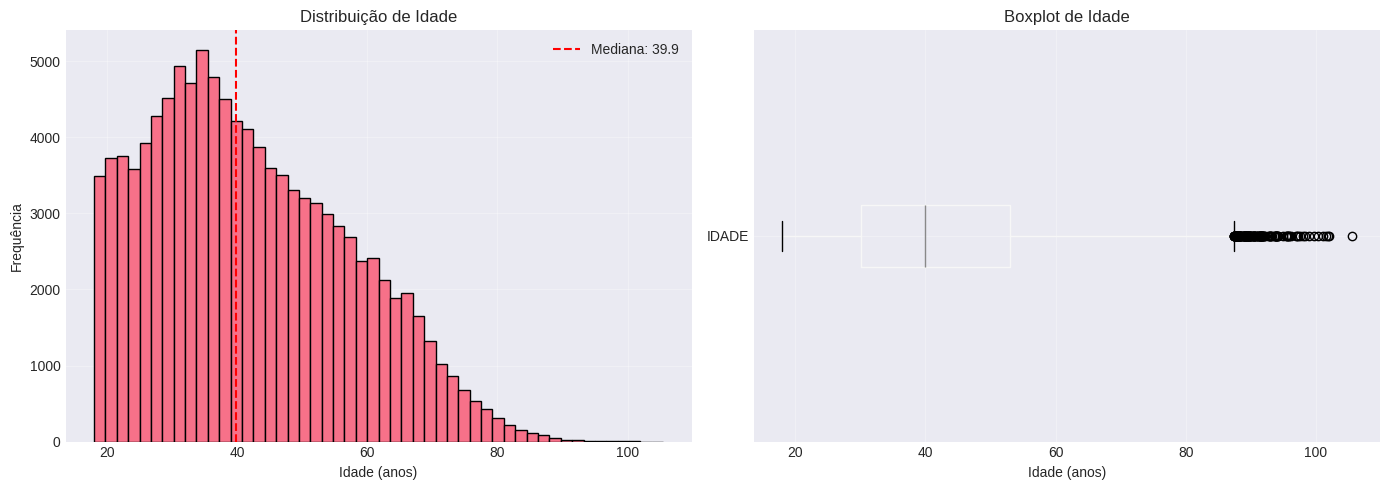

In [23]:
# Estatísticas de idade
print("=" * 80)
print("ANÁLISE DE IDADE")
print("=" * 80)

idade_stats = df['IDADE'].describe()
print("\nEstatísticas descritivas:")
display(idade_stats)

# Quartis
q25, q50, q75 = df['IDADE'].quantile([0.25, 0.5, 0.75])
print(f"\nQuartis:")
print(f"   • Q1 (25%): {q25:.2f} anos")
print(f"   • Q2 (50% - Mediana): {q50:.2f} anos")
print(f"   • Q3 (75%): {q75:.2f} anos")

# Outliers
n_idade_neg = (df['IDADE'] < 18).sum()
n_idade_gt120 = (df['IDADE'] > 120).sum()
print(f"\nOutliers:")
print(f"   • Idade < 18: {n_idade_neg:,}")
print(f"   • Idade > 120: {n_idade_gt120:,}")

# Faixas etárias
def criar_faixa_etaria(idade):
    if pd.isna(idade):
        return 'Não informado'
    elif idade < 18:
        return '<18'
    elif idade < 25:
        return '18-24'
    elif idade < 35:
        return '25-34'
    elif idade < 45:
        return '35-44'
    elif idade < 60:
        return '45-59'
    else:
        return '60+'

df['faixa_etaria'] = df['IDADE'].apply(criar_faixa_etaria)

print("\n👥 Distribuição por faixa etária:")
faixa_dist = df['faixa_etaria'].value_counts().sort_index()
display(faixa_dist)

# Visualizações
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df['IDADE'].hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].axvline(q50, color='red', linestyle='--', label=f'Mediana: {q50:.1f}')
axes[0].set_xlabel('Idade (anos)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição de Idade')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
df.boxplot(column='IDADE', ax=axes[1], vert=False)
axes[1].set_xlabel('Idade (anos)')
axes[1].set_title('Boxplot de Idade')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 OBITO e CLASSE_SOCIAL

OBITO - INDICADOR DE ÓBITO

📊 Valores únicos (excluindo nulos): 1
   Valores nulos (não houve óbito): 120,548 (99.83%)

📋 Distribuição:

💡 Interpretação:
   • NaN (nulo) = Não houve óbito
   • 'S' = Sim, houve óbito

📈 Estatísticas:
   • Casos COM óbito: 202 (0.17%)
   • Casos SEM óbito: 120,548 (99.83%)


OBITO
NaN    120548
S         202
Name: count, dtype: int64


CLASSE_SOCIAL

📊 Valores únicos (excluindo nulos): 5
   Valores nulos (classe não informada): 53,110 (43.98%)

📋 Distribuição (normalizado):


CLASSE_SOCIAL_NORM
e      54928
NaN    53110
d       9130
c       2972
b        449
a        161
Name: count, dtype: int64

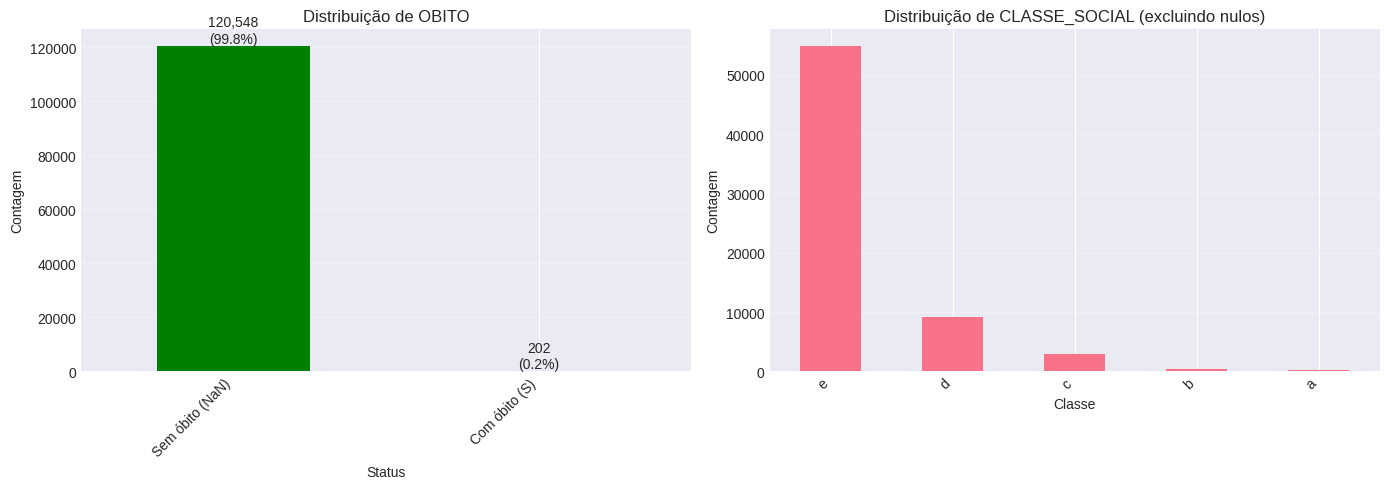


💡 Nota: 44.0% dos registros não têm classe social informada
   Isso pode indicar falta de dados ou impossibilidade de classificação


In [ ]:
# OBITO
print("=" * 80)
print("OBITO - INDICADOR DE ÓBITO")
print("=" * 80)

obito_stats = validate_column_values(df, 'OBITO')
print(f"\nValores únicos (excluindo nulos): {obito_stats['n_unique']}")
print(f"   Valores nulos (não houve óbito): {obito_stats['n_null']:,} ({obito_stats['pct_null']:.2f}%)")

print("\nDistribuição:")
print("\nInterpretação:")
print("   • NaN (nulo) = Não houve óbito")
print("   • 'S' = Sim, houve óbito")

# Calcular contagem de óbitos
n_obitos = df['OBITO'].notna().sum()
n_sem_obito = df['OBITO'].isna().sum()
pct_obitos = (n_obitos / len(df)) * 100

print(f"\nEstatísticas:")
print(f"   • Casos COM óbito: {n_obitos:,} ({pct_obitos:.2f}%)")
print(f"   • Casos SEM óbito: {n_sem_obito:,} ({100-pct_obitos:.2f}%)")

display(obito_stats['value_counts'])

# CLASSE_SOCIAL
print("\n" + "=" * 80)
print("CLASSE_SOCIAL")
print("=" * 80)

# Normalizar apenas valores não-nulos
# Preservar NaN como nulo verdadeiro
df['CLASSE_SOCIAL_NORM'] = df['CLASSE_SOCIAL'].apply(
    lambda x: x.lower().strip() if pd.notna(x) else x
)

classe_stats = validate_column_values(df, 'CLASSE_SOCIAL_NORM')
print(f"\nValores únicos (excluindo nulos): {classe_stats['n_unique']}")
print(f"   Valores nulos (classe não informada): {classe_stats['n_null']:,} ({classe_stats['pct_null']:.2f}%)")

print("\nDistribuição (normalizado):")
display(classe_stats['value_counts'])

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mostrar contagem de óbitos
obito_data = pd.Series({
    'Sem óbito (NaN)': n_sem_obito,
    'Com óbito (S)': n_obitos
})
obito_data.plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Distribuição de OBITO')
axes[0].set_ylabel('Contagem')
axes[0].set_xlabel('Status')
axes[0].grid(True, alpha=0.3, axis='y')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Adicionar valores nas barras
for i, val in enumerate(obito_data.values):
    axes[0].text(i, val, f'{val:,}\n({val/len(df)*100:.1f}%)', 
                ha='center', va='bottom', fontsize=10)

# CLASSE_SOCIAL (excluindo nulos para melhor visualização)
classe_counts = df['CLASSE_SOCIAL_NORM'].value_counts()
classe_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribuição de CLASSE_SOCIAL (excluindo nulos)')
axes[1].set_ylabel('Contagem')
axes[1].set_xlabel('Classe')
axes[1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Insight sobre nulos em CLASSE_SOCIAL
print(f"\nNota: {classe_stats['pct_null']:.1f}% dos registros não têm classe social informada")

## 5. Análises Bivariadas - Relação com TARGET (Inadimplência)

Analisando a taxa de inadimplência por cada dimensão, aplicando k-anonimato (k=20 por padrão).

In [ ]:
# Taxa global de inadimplência
print("=" * 80)
print("TAXA GLOBAL DE INADIMPLÊNCIA")
print("=" * 80)

taxa_global = calc_target_rate(df)
print(f"\nTaxa global: {taxa_global['taxa_inad'].iloc[0]*100:.2f}%")
print(f"   IC 95%: [{taxa_global['ic_lower'].iloc[0]*100:.2f}%, {taxa_global['ic_upper'].iloc[0]*100:.2f}%]")
print(f"   n = {taxa_global['n'].iloc[0]:,}")

# Definir k-anonimato
K_ANONYMITY = 20
print(f"\n K-anonimato definido: k = {K_ANONYMITY}")
print(f"   (Grupos com n < {K_ANONYMITY} serão filtrados)")

display(taxa_global)

TAXA GLOBAL DE INADIMPLÊNCIA

🎯 Taxa global: 24.50%
   IC 95%: [24.26%, 24.75%]
   n = 120,750

🔒 K-anonimato definido: k = 20
   (Grupos com n < 20 serão filtrados)


,n,taxa_inad,ic_lower,ic_upper
0,120750,0.2450,0.2426,0.2475



TAXA DE INADIMPLÊNCIA POR UF

📊 28 UFs com n >= 20

Top 10 UFs com MAIOR taxa de inadimplência:


,UF,n,taxa_inad,std_err,ic_lower,ic_upper
3,AP,1292,0.3212,0.0130,0.2957,0.3467
1,AL,2800,0.2968,0.0086,0.2799,0.3137
21,RR,573,0.2932,0.0190,0.2559,0.3305
24,SE,1175,0.2851,0.0132,0.2593,0.3109
19,RN,3800,0.2797,0.0073,0.2655,0.2940
15,PE,7056,0.2701,0.0053,0.2598,0.2805
14,PB,3085,0.2674,0.0080,0.2518,0.2830
2,AM,4145,0.2634,0.0068,0.2500,0.2769
13,PA,10159,0.2585,0.0043,0.2500,0.2670
27,NaN,3356,0.2539,0.0075,0.2391,0.2686



Top 10 UFs com MENOR taxa de inadimplência:


,UF,n,taxa_inad,std_err,ic_lower,ic_upper
26,TO,767,0.2256,0.0151,0.1960,0.2551
22,RS,8410,0.2219,0.0045,0.2130,0.2308
16,PI,1858,0.2212,0.0096,0.2023,0.2401
10,MG,7757,0.2186,0.0047,0.2094,0.2278
17,PR,3668,0.2075,0.0067,0.1943,0.2206
20,RO,1731,0.2028,0.0097,0.1838,0.2217
12,MT,2015,0.2015,0.0089,0.1840,0.2190
0,AC,2304,0.1997,0.0083,0.1833,0.2160
11,MS,2515,0.1992,0.0080,0.1836,0.2148
23,SC,2013,0.1962,0.0089,0.1789,0.2136


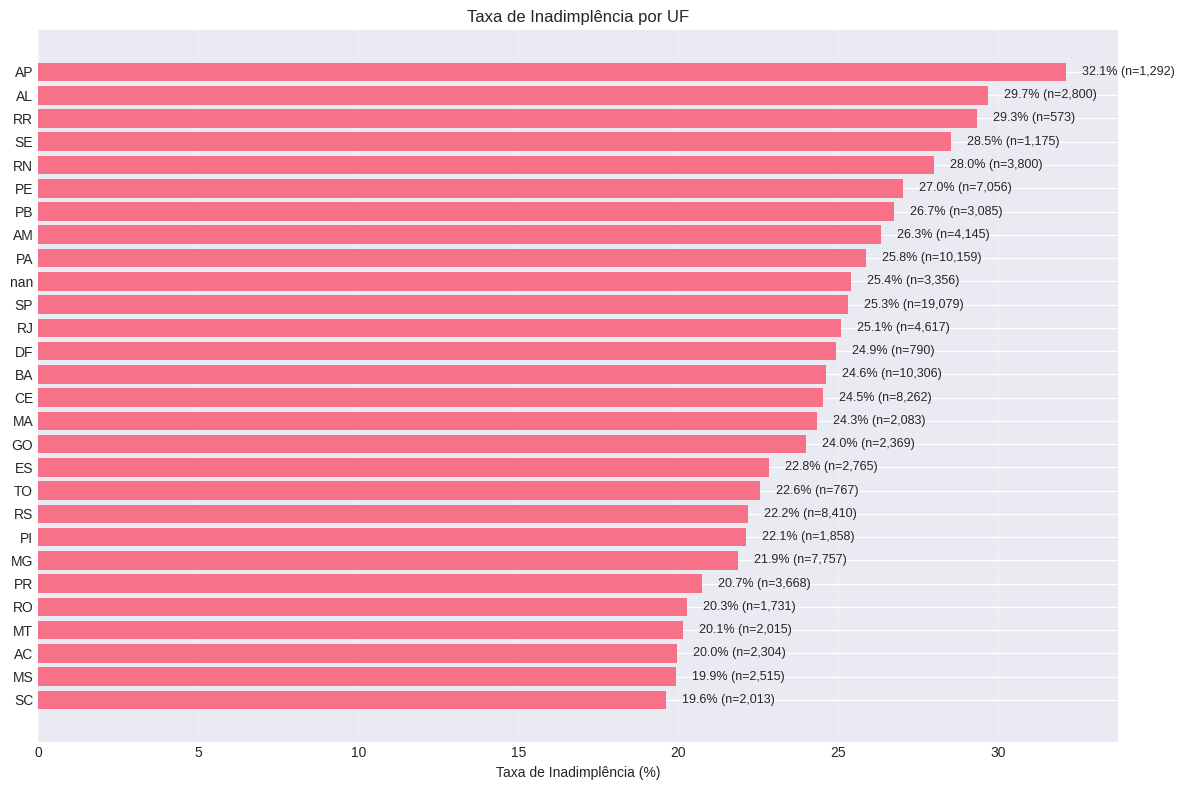

In [ ]:
# Taxa por UF
print("\n" + "=" * 80)
print("TAXA DE INADIMPLÊNCIA POR UF")
print("=" * 80)

taxa_uf = calc_target_rate(df, group_by=['UF'], min_count=K_ANONYMITY)
print(f"\n {len(taxa_uf)} UFs com n >= {K_ANONYMITY}")
print(f"\nTop 10 UFs com MAIOR taxa de inadimplência:")
display(taxa_uf.head(10))

print(f"\nTop 10 UFs com MENOR taxa de inadimplência:")
display(taxa_uf.tail(10))

# Visualização
plot_target_by_group(df, 'UF', min_count=K_ANONYMITY, figsize=(12, 8))


TAXA DE INADIMPLÊNCIA POR SEXO


,SEXO,n,taxa_inad,std_err,ic_lower,ic_upper
2,NaN,14619,0.3068,0.0038,0.2993,0.3143
1,M,46000,0.2681,0.0021,0.2640,0.2721
0,F,60131,0.2124,0.0017,0.2091,0.2157



TAXA DE INADIMPLÊNCIA POR CLASSE SOCIAL


,CLASSE_SOCIAL_NORM,n,taxa_inad,std_err,ic_lower,ic_upper
0,a,161,0.3292,0.0370,0.2566,0.4018
1,b,449,0.3140,0.0219,0.2711,0.3570
5,NaN,53110,0.2562,0.0019,0.2525,0.2599
4,e,54928,0.2425,0.0018,0.2389,0.2461
2,c,2972,0.2332,0.0078,0.2180,0.2484
3,d,9130,0.1945,0.0041,0.1864,0.2026



TAXA DE INADIMPLÊNCIA POR FAIXA ETÁRIA


,faixa_etaria,n,taxa_inad,std_err,ic_lower,ic_upper
5,Não informado,13710,0.3137,0.0040,0.3059,0.3215
0,18-24,14521,0.3106,0.0038,0.3031,0.3181
1,25-34,26034,0.2723,0.0028,0.2669,0.2777
2,35-44,24546,0.2400,0.0027,0.2347,0.2454
3,45-59,26071,0.2031,0.0025,0.1983,0.2080
4,60+,15868,0.1574,0.0029,0.1518,0.1631


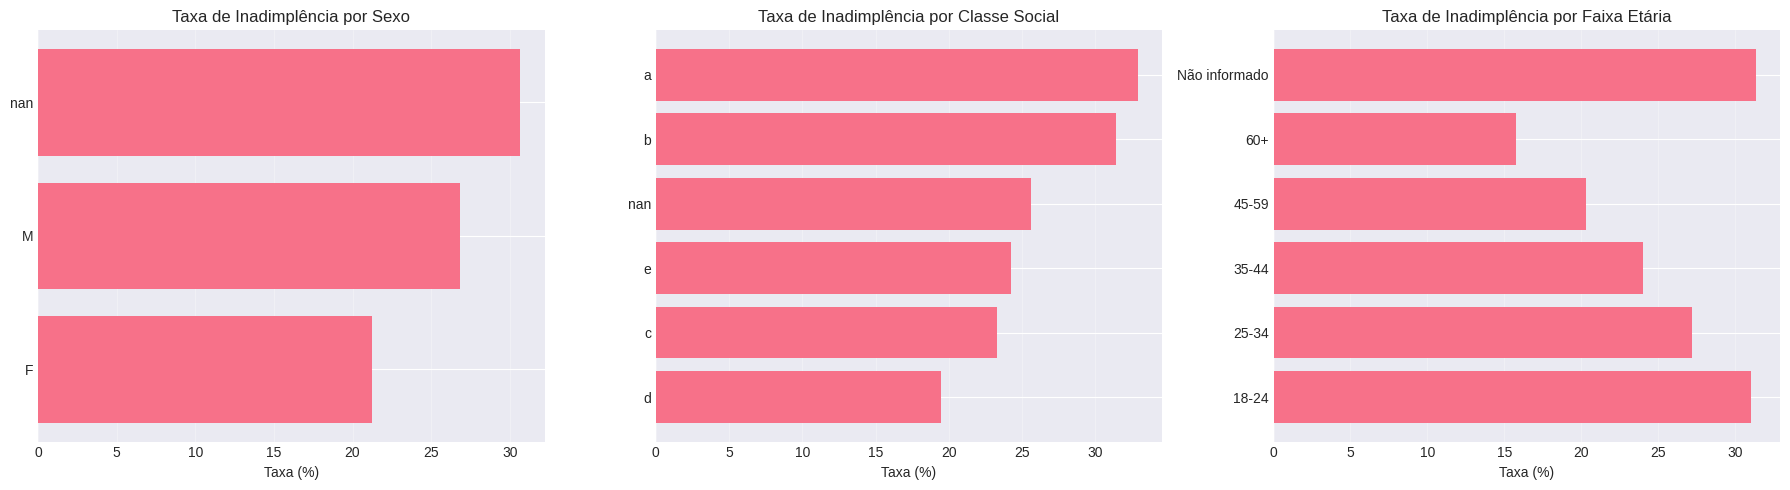

In [27]:
# Taxa por Sexo
print("\n" + "=" * 80)
print("TAXA DE INADIMPLÊNCIA POR SEXO")
print("=" * 80)

taxa_sexo = calc_target_rate(df, group_by=['SEXO'], min_count=K_ANONYMITY)
display(taxa_sexo)

# Taxa por Classe Social
print("\n" + "=" * 80)
print("TAXA DE INADIMPLÊNCIA POR CLASSE SOCIAL")
print("=" * 80)

taxa_classe = calc_target_rate(df, group_by=['CLASSE_SOCIAL_NORM'], min_count=K_ANONYMITY)
display(taxa_classe)

# Taxa por Faixa Etária
print("\n" + "=" * 80)
print("TAXA DE INADIMPLÊNCIA POR FAIXA ETÁRIA")
print("=" * 80)

taxa_faixa = calc_target_rate(df, group_by=['faixa_etaria'], min_count=K_ANONYMITY)
display(taxa_faixa)

# Visualizações lado a lado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sexo
taxa_sexo_sorted = taxa_sexo.sort_values('taxa_inad', ascending=True)
axes[0].barh(range(len(taxa_sexo_sorted)), taxa_sexo_sorted['taxa_inad'] * 100)
axes[0].set_yticks(range(len(taxa_sexo_sorted)))
axes[0].set_yticklabels(taxa_sexo_sorted['SEXO'])
axes[0].set_xlabel('Taxa (%)')
axes[0].set_title('Taxa de Inadimplência por Sexo')
axes[0].grid(True, alpha=0.3, axis='x')

# Classe
taxa_classe_sorted = taxa_classe.sort_values('taxa_inad', ascending=True)
axes[1].barh(range(len(taxa_classe_sorted)), taxa_classe_sorted['taxa_inad'] * 100)
axes[1].set_yticks(range(len(taxa_classe_sorted)))
axes[1].set_yticklabels(taxa_classe_sorted['CLASSE_SOCIAL_NORM'])
axes[1].set_xlabel('Taxa (%)')
axes[1].set_title('Taxa de Inadimplência por Classe Social')
axes[1].grid(True, alpha=0.3, axis='x')

# Faixa Etária
# Ordenar por ordem lógica de faixa
faixa_order = ['<18', '18-24', '25-34', '35-44', '45-59', '60+', 'Não informado']
taxa_faixa['faixa_etaria'] = pd.Categorical(taxa_faixa['faixa_etaria'], categories=faixa_order, ordered=True)
taxa_faixa_sorted = taxa_faixa.sort_values('faixa_etaria')
axes[2].barh(range(len(taxa_faixa_sorted)), taxa_faixa_sorted['taxa_inad'] * 100)
axes[2].set_yticks(range(len(taxa_faixa_sorted)))
axes[2].set_yticklabels(taxa_faixa_sorted['faixa_etaria'])
axes[2].set_xlabel('Taxa (%)')
axes[2].set_title('Taxa de Inadimplência por Faixa Etária')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 6. Análises Temporais - Evolução ao Longo do Tempo

SÉRIE TEMPORAL MENSAL

📊 Série de 8 meses:


,mes,n,taxa_inad,mes_str
0,2017-01,14537,0.2367,2017-01
1,2017-02,13697,0.2254,2017-02
2,2017-03,16046,0.4955,2017-03
3,2017-04,13500,0.2070,2017-04
4,2017-05,14220,0.2089,2017-05
5,2017-06,15057,0.1969,2017-06
6,2017-07,16445,0.1875,2017-07
7,2017-08,17248,0.1910,2017-08


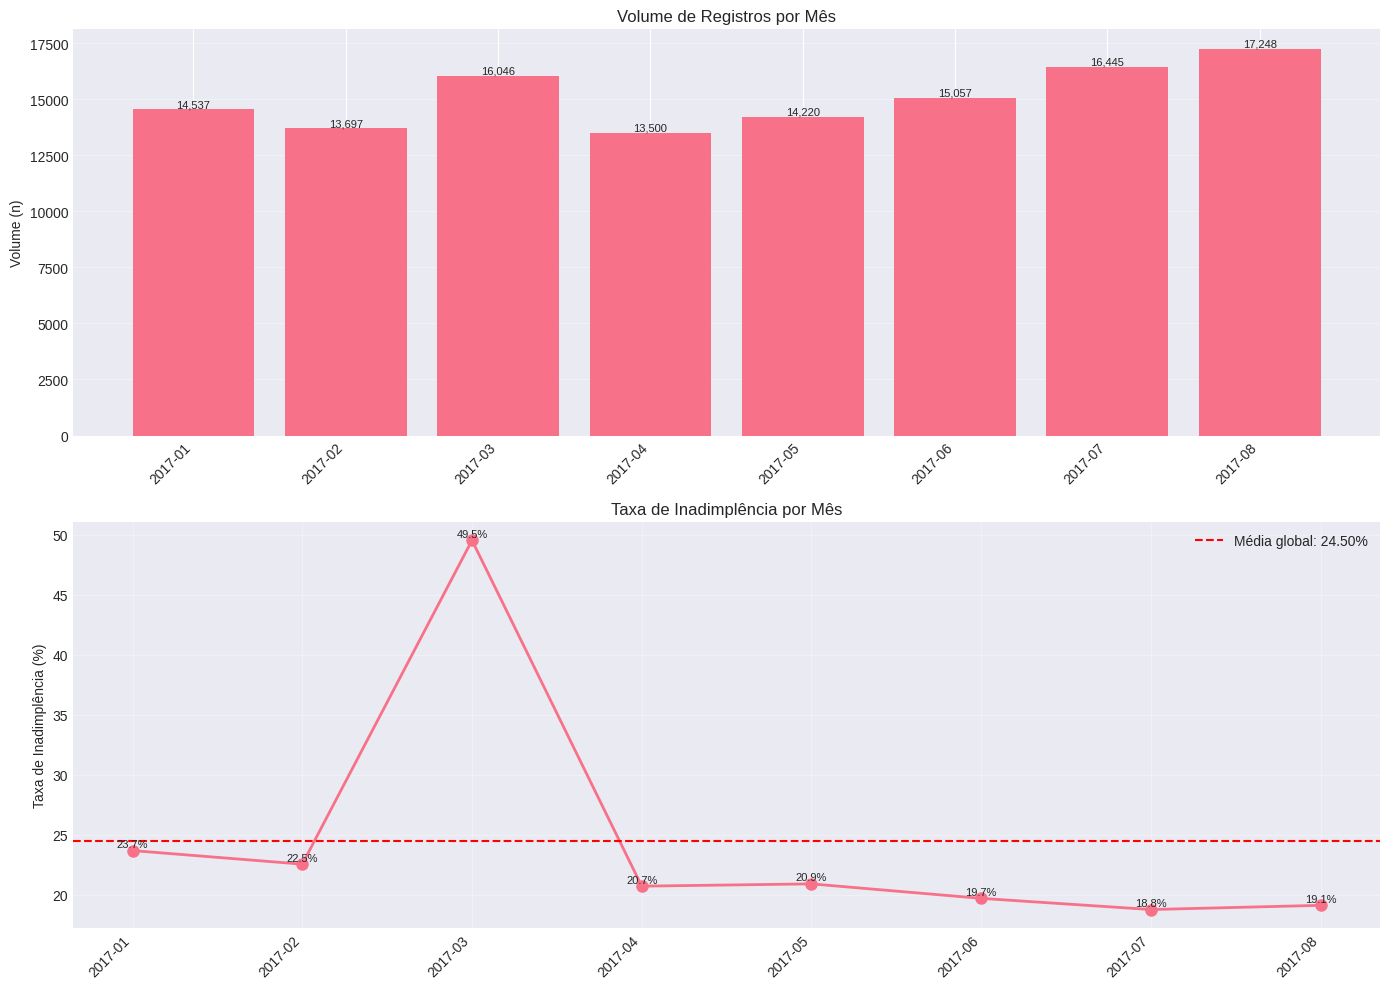


💡 Insights:
   • Mês com MAIOR volume: 2017-08 (17,248 registros)
   • Mês com MENOR volume: 2017-04 (13,500 registros)
   • Mês com MAIOR taxa inadimplência: 2017-03 (49.55%)
   • Mês com MENOR taxa inadimplência: 2017-07 (18.75%)


In [ ]:
# Criar coluna de mês
df['mes'] = df['REF_DATE'].dt.to_period('M')

# Série mensal: volume e taxa
print("=" * 80)
print("SÉRIE TEMPORAL MENSAL")
print("=" * 80)

serie_mensal = df.groupby('mes').agg(
    n=('TARGET', 'count'),
    taxa_inad=('TARGET', 'mean')
).reset_index()

# Converter período para string para visualização
serie_mensal['mes_str'] = serie_mensal['mes'].astype(str)

print(f"\n Série de {len(serie_mensal)} meses:")
display(serie_mensal)

# Visualizações
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Volume por mês
axes[0].bar(range(len(serie_mensal)), serie_mensal['n'])
axes[0].set_xticks(range(len(serie_mensal)))
axes[0].set_xticklabels(serie_mensal['mes_str'], rotation=45, ha='right')
axes[0].set_ylabel('Volume (n)')
axes[0].set_title('Volume de Registros por Mês')
axes[0].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for i, (idx, row) in enumerate(serie_mensal.iterrows()):
    axes[0].text(i, row['n'], f"{row['n']:,}", ha='center', va='bottom', fontsize=8)

# Taxa de inadimplência por mês
axes[1].plot(range(len(serie_mensal)), serie_mensal['taxa_inad'] * 100, 
             marker='o', linewidth=2, markersize=8)
axes[1].set_xticks(range(len(serie_mensal)))
axes[1].set_xticklabels(serie_mensal['mes_str'], rotation=45, ha='right')
axes[1].set_ylabel('Taxa de Inadimplência (%)')
axes[1].set_title('Taxa de Inadimplência por Mês')
axes[1].grid(True, alpha=0.3)

# Linha de referência (taxa global)
taxa_global_val = df['TARGET'].mean() * 100
axes[1].axhline(taxa_global_val, color='red', linestyle='--', 
                label=f'Média global: {taxa_global_val:.2f}%')
axes[1].legend()

# Adicionar valores nos pontos
for i, (idx, row) in enumerate(serie_mensal.iterrows()):
    axes[1].text(i, row['taxa_inad'] * 100 + 0.3, f"{row['taxa_inad']*100:.1f}%", 
                ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Insights
print("\n Insights:")
mes_maior_volume = serie_mensal.loc[serie_mensal['n'].idxmax()]
mes_menor_volume = serie_mensal.loc[serie_mensal['n'].idxmin()]
mes_maior_taxa = serie_mensal.loc[serie_mensal['taxa_inad'].idxmax()]
mes_menor_taxa = serie_mensal.loc[serie_mensal['taxa_inad'].idxmin()]

print(f"   • Mês com MAIOR volume: {mes_maior_volume['mes_str']} ({mes_maior_volume['n']:,} registros)")
print(f"   • Mês com MENOR volume: {mes_menor_volume['mes_str']} ({mes_menor_volume['n']:,} registros)")
print(f"   • Mês com MAIOR taxa inadimplência: {mes_maior_taxa['mes_str']} ({mes_maior_taxa['taxa_inad']*100:.2f}%)")
print(f"   • Mês com MENOR taxa inadimplência: {mes_menor_taxa['mes_str']} ({mes_menor_taxa['taxa_inad']*100:.2f}%)")

## 7. Análises Multivariadas - Cruzamentos entre Dimensões

Analisando combinações de dimensões para identificar perfis de risco.

TAXA DE INADIMPLÊNCIA: UF × SEXO

📊 84 combinações com n >= 20

Top 10 combinações com MAIOR taxa:


,UF,SEXO,n,taxa_inad,std_err,ic_lower,ic_upper
11,AP,NaN,230,0.4565,0.0328,0.3921,0.5209
65,RR,NaN,99,0.4141,0.0495,0.3171,0.5112
8,AM,NaN,583,0.3894,0.0202,0.3498,0.4289
59,RN,NaN,468,0.3590,0.0222,0.3155,0.4024
5,AL,NaN,339,0.3569,0.0260,0.3059,0.4079
80,TO,NaN,88,0.3409,0.0505,0.2419,0.4399
44,PB,NaN,399,0.3383,0.0237,0.2919,0.3848
10,AP,M,501,0.3333,0.0211,0.2921,0.3746
4,AL,M,1073,0.3318,0.0144,0.3036,0.3600
41,PA,NaN,1496,0.3189,0.0120,0.2952,0.3425



Top 10 combinações com MENOR taxa:


,UF,SEXO,n,taxa_inad,std_err,ic_lower,ic_upper
21,ES,F,1472,0.1902,0.0102,0.1702,0.2103
24,GO,F,1103,0.1895,0.0118,0.1664,0.2126
30,MG,F,4052,0.1868,0.0061,0.1748,0.1988
51,PR,F,1743,0.1773,0.0091,0.1594,0.1952
78,TO,F,379,0.1768,0.0196,0.1384,0.2152
0,AC,F,1141,0.1762,0.0113,0.1541,0.1983
69,SC,F,999,0.1752,0.0120,0.1516,0.1987
33,MS,F,1118,0.1708,0.0113,0.1488,0.1929
36,MT,F,885,0.1695,0.0126,0.1448,0.1942
60,RO,F,782,0.1650,0.0133,0.1389,0.1910


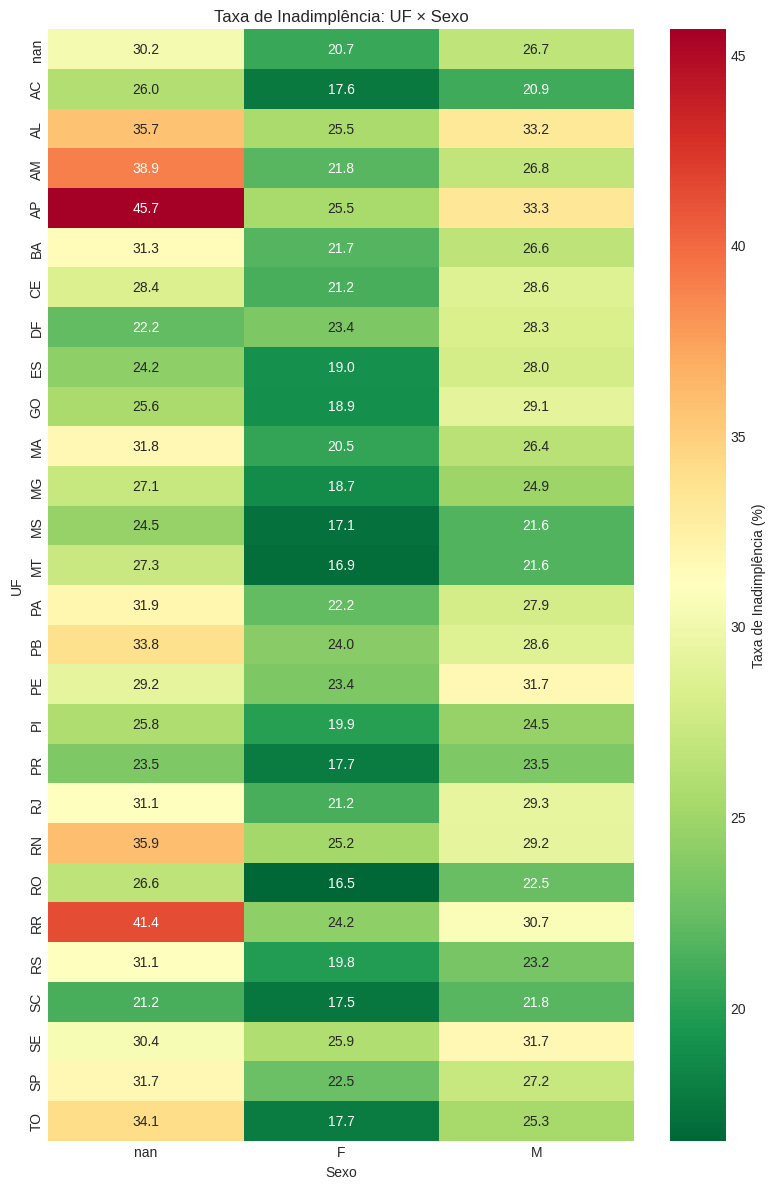

In [ ]:
# UF × Sexo
print("=" * 80)
print("TAXA DE INADIMPLÊNCIA: UF × SEXO")
print("=" * 80)

taxa_uf_sexo = calc_target_rate(df, group_by=['UF', 'SEXO'], min_count=K_ANONYMITY)
print(f"\n {len(taxa_uf_sexo)} combinações com n >= {K_ANONYMITY}")
print(f"\nTop 10 combinações com MAIOR taxa:")
display(taxa_uf_sexo.head(10))

print(f"\nTop 10 combinações com MENOR taxa:")
display(taxa_uf_sexo.tail(10))

# Heatmap: UF × Sexo
pivot_uf_sexo = taxa_uf_sexo.pivot(index='UF', columns='SEXO', values='taxa_inad')

plt.figure(figsize=(8, 12))
sns.heatmap(pivot_uf_sexo * 100, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Taxa de Inadimplência (%)'})
plt.title('Taxa de Inadimplência: UF × Sexo')
plt.ylabel('UF')
plt.xlabel('Sexo')
plt.tight_layout()
plt.show()


TAXA DE INADIMPLÊNCIA: SEXO × CLASSE SOCIAL

📊 16 combinações com n >= 20


,SEXO,CLASSE_SOCIAL_NORM,n,taxa_inad,std_err,ic_lower,ic_upper
7,M,b,212,0.3538,0.0328,0.2894,0.4181
6,M,a,79,0.3291,0.0529,0.2255,0.4327
0,F,a,80,0.3250,0.0524,0.2224,0.4276
17,NaN,NaN,14018,0.3114,0.0039,0.3037,0.3191
11,M,NaN,14344,0.2818,0.0038,0.2744,0.2892
1,F,b,228,0.2719,0.0295,0.2142,0.3297
10,M,e,24846,0.2715,0.0028,0.2659,0.2770
8,M,c,1363,0.2597,0.0119,0.2364,0.2830
4,F,e,29606,0.2186,0.0024,0.2139,0.2233
16,NaN,e,476,0.2143,0.0188,0.1774,0.2511


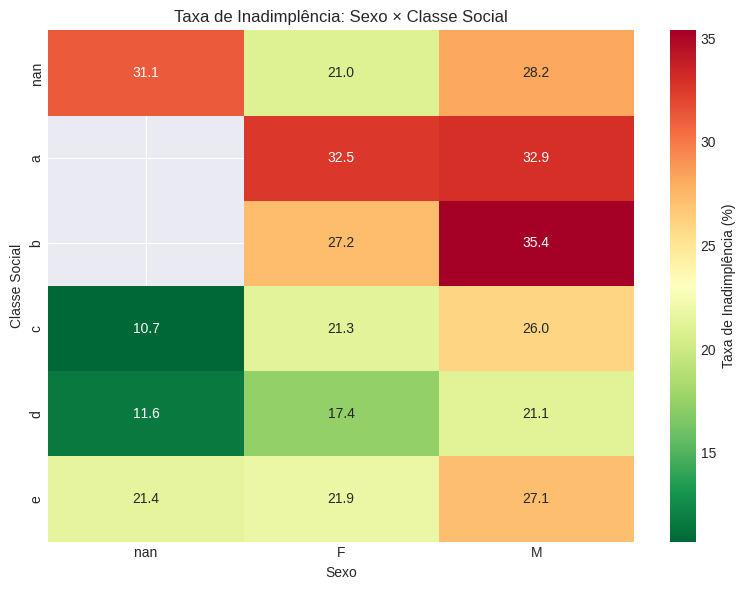


TAXA DE INADIMPLÊNCIA: FAIXA ETÁRIA × SEXO

📊 16 combinações com n >= 20


,faixa_etaria,SEXO,n,taxa_inad,std_err,ic_lower,ic_upper
1,18-24,M,6612,0.3244,0.0058,0.3131,0.3357
17,Não informado,NaN,13695,0.3140,0.0040,0.3062,0.3218
4,25-34,M,11717,0.3096,0.0043,0.3012,0.3179
0,18-24,F,7820,0.2995,0.0052,0.2893,0.3096
7,35-44,M,10601,0.2719,0.0043,0.2634,0.2803
2,18-24,NaN,89,0.2584,0.0464,0.1675,0.3494
8,35-44,NaN,216,0.2454,0.0293,0.1880,0.3028
3,25-34,F,14149,0.2426,0.0036,0.2355,0.2496
10,45-59,M,10573,0.2383,0.0041,0.2302,0.2465
6,35-44,F,13729,0.2154,0.0035,0.2085,0.2223


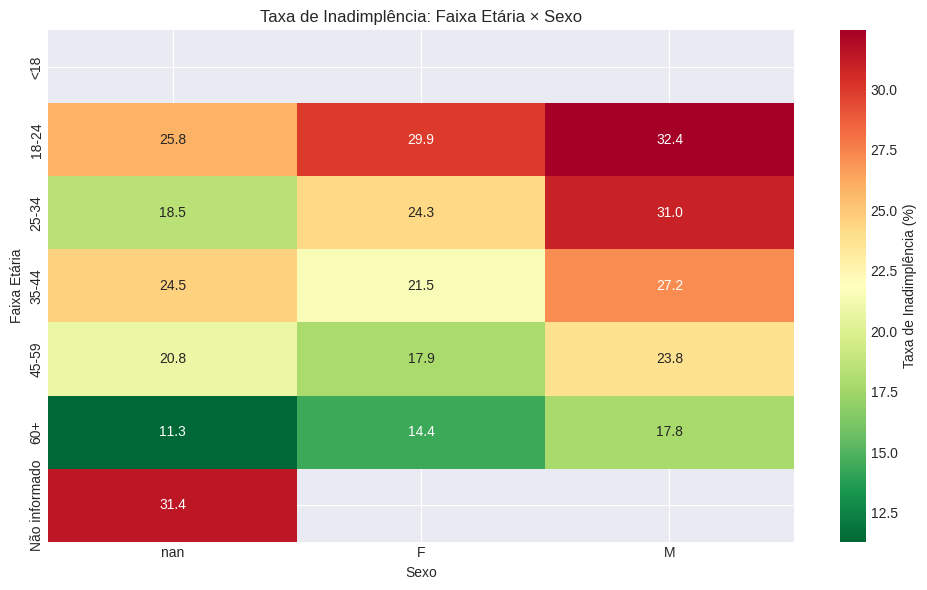

In [ ]:
# Sexo × Classe Social
print("\n" + "=" * 80)
print("TAXA DE INADIMPLÊNCIA: SEXO × CLASSE SOCIAL")
print("=" * 80)

taxa_sexo_classe = calc_target_rate(df, group_by=['SEXO', 'CLASSE_SOCIAL_NORM'], min_count=K_ANONYMITY)
print(f"\n {len(taxa_sexo_classe)} combinações com n >= {K_ANONYMITY}")
display(taxa_sexo_classe)

# Heatmap
pivot_sexo_classe = taxa_sexo_classe.pivot(index='CLASSE_SOCIAL_NORM', columns='SEXO', values='taxa_inad')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_sexo_classe * 100, annot=True, fmt='.1f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Taxa de Inadimplência (%)'})
plt.title('Taxa de Inadimplência: Sexo × Classe Social')
plt.ylabel('Classe Social')
plt.xlabel('Sexo')
plt.tight_layout()
plt.show()

# Faixa Etária × Sexo
print("\n" + "=" * 80)
print("TAXA DE INADIMPLÊNCIA: FAIXA ETÁRIA × SEXO")
print("=" * 80)

taxa_faixa_sexo = calc_target_rate(df, group_by=['faixa_etaria', 'SEXO'], min_count=K_ANONYMITY)
print(f"\n {len(taxa_faixa_sexo)} combinações com n >= {K_ANONYMITY}")
display(taxa_faixa_sexo)

# Visualização
faixa_order = ['<18', '18-24', '25-34', '35-44', '45-59', '60+', 'Não informado']
pivot_faixa_sexo = taxa_faixa_sexo.pivot(index='faixa_etaria', columns='SEXO', values='taxa_inad')
pivot_faixa_sexo = pivot_faixa_sexo.reindex(faixa_order)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_faixa_sexo * 100, annot=True, fmt='.1f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Taxa de Inadimplência (%)'})
plt.title('Taxa de Inadimplência: Faixa Etária × Sexo')
plt.ylabel('Faixa Etária')
plt.xlabel('Sexo')
plt.tight_layout()
plt.show()

# 8. Conclusão

Com base na análise, pudemos definir:

## 8.1 Tratamento necessário
- Quando a pessoa ainda estava viva, o OBITO retornava como NaN em vez de "Não". O chat estará preparado para entender essa informação.
- Para demais casos, o chat retornará nulos como não informado, pois a ausência de informação, nesse caso, era uma informação. Como se trata de um chatbot de análise especificamente, faz mais sentido manter e marcar como "Não informado" por segurança do que de fato adotar alguma estratégia de preenchimento ou exclusão de dados.
- Apesar dos dados estarem desbalanceados, pelo propósito da tarefa, não faria sentido balancear.
- Não houve outliers significativos. Uma importante verificação que fizemos foi em relação a idade, em que não havia menores de idade (conforme a LGPD) nem pessoas com uma idade muito alta que não fosse condizente com a realidade.

## 8.2 Insights obtidos
- Observamos que manter os nulos distorce análises multivariadas, sendo necessário desconsiderá-los para que seja mais eficiente.
- Observamos que conectar uma tool de busca na web pode ser interessante para auxiliar o analista a entender porque determinado mês, por exemplo, teve alta ou baixa, buscando fontes externas para entender sazonalidade dentro daquele tema ou possíveis acontecimentos de larga escala que tenham provocado isso.
- Observamos que a distribuição de classes, idade, sexo, etc., estava condizente com a realidade, além de entender questões basais do dataset, como volumetria, range de data, etc. Pudemos também analisar o comportamento dessas variáveis em relação a quartis e a distribuição desses dados.
    - Total de registros: 120,750
    - Período: 2017-01-02 a 2017-08-31
    - Amplitude temporal: 8 meses
    - Taxa de Inadimplência Global: 24.50%
    - Idade:
      - Média: 42.1 anos
      - Mediana: 39.9 anos
      - Amplitude: 18.0 a 105.5 anos
    - UF: 27/27
    - Distribuição Social: classes sociais de A-E presentes.
- Observamos possíveis perfis dentro da inadimplência. Por exemplo, homens da Classe Social B são mais propensos a serem inadimplentes em relação a outros perfis com este mesmo cruzamento. 
    - Por UF:
      - MAIOR taxa: AP (32.12%, n=1,292)
      - MENOR taxa: SC (19.62%, n=2,013)
      - Amplitude: 12.50 pontos percentuais

   - Por Sexo:
      - M: 26.81% (n=46,000)
      - F: 21.24% (n=60,131)

   - Por Classe Social:
      - MAIOR taxa: a (32.92%)

   - Temporal:
      - Mês com maior volume: 2017-08
      - Mês com maior taxa: 2017-03 (49.55%)
- Observamos possíveis análises que podem ser realizadas por um analista, além de estabelecer um gabarito de verificação durante nossos testes iniciais enquanto implementamos.
- Observamos, ao comparar tabelas e gráficos, que as informações de fato são complementares e que o suporte a visualização é uma feature essencial, não adicional.
- Em melhorias futuras, podemos incluir suporte a análises estatísticas mais avançadas específicas para o processo de modelagem, por exemplo, como  teste de Kolmogorov-Smirnov (KS).

## 8.3 Guardrails e recomendações para o chatbot

1) Definimos um k-anonimato de 20 (ou seja, grupos com menos observações serão filtrados). Isso visaria garantir a legitimidade das consultas, o que faria sentido para consultas externas. Para o caso de consultas a analistas que teriam acesso a dados brutos, não seria necessário.
2) Por padrão, as queries retornarão no máximo 100 linhas (LIMIT=100).
3) Por padrão, utilizaremos o período completo dos dados disponíveis, de 2017-01-02 a 2017-08-31.
4) É importante definir um timeout de query de 10s. Queries que demorarem mais que esse valor serão canceladas.
5) Apenas SELECTs (ou seja, operações read-only) serão permitidos. Como o objetivo é um chatbot de análise dos dados disponíveis, as operações de DROP, DELETE, UPDATE, INSERT, CREATE, ALTER, TRUNCATE devem ser bloqueadas.
6) O máximo de linhas permitido em uma amostra será de 10.000, para proteger de queries que retornem o dataset completo.
7) Definição de padrões de formatação para respostas:
    - Percentuais: 2 casas decimais, separador ','
     Exemplo: 15,25%
    - Idade: 1 casa decimal
     Exemplo: 35,7 anos
    - Números grandes: separador de milhar '.'
     Exemplo: 123.456
    - Datas: formato %d/%m/%Y
     Exemplo: 01/06/2017

